In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Detected object: car, Confidence: 1.00, Box: [175.52458 152.99973 420.18564 275.81174]


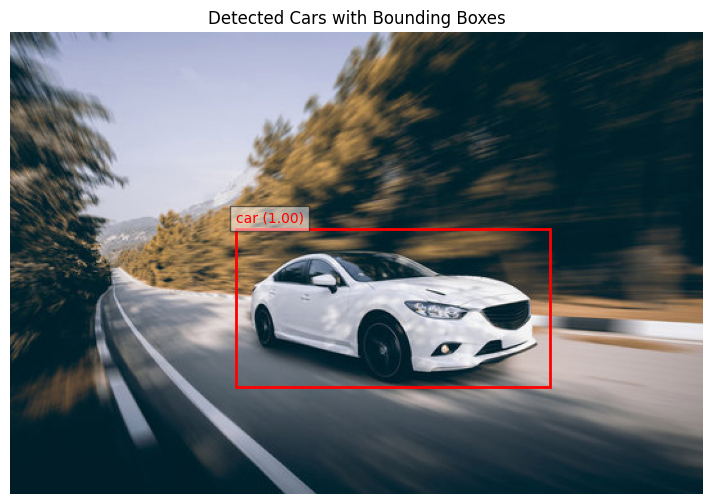

In [ ]:
# Load the fine-tuned Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=False)  # Initialize the model
num_classes = 2  # 1 class (car) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Get the number of input features for the classifier
# Replace the pre-trained head with a new one for our specific number of classes
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
# Load the fine-tuned model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/faster_rcnn_finetuned.pth"))
model.to(device)  # Move the model to the appropriate device (CPU or GPU)
model.eval()  # Set the model to evaluation mode

# Load the test image
test_image_path = "/content/drive/MyDrive/car.jpg"  # Path to the test image
img = Image.open(test_image_path).convert("RGB")  # Open the image and convert it to RGB
img_tensor = ToTensor()(img)  # Convert the image to a tensor
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension to the tensor

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    img_tensor = img_tensor.to(device)  # Move the input tensor to the same device as the model
    prediction = model(img_tensor)  # Get predictions from the model

# Process predictions
boxes = prediction[0]['boxes'].cpu().numpy()  # Extract bounding boxes and move to CPU
labels = prediction[0]['labels'].cpu().numpy()  # Extract labels and move to CPU
scores = prediction[0]['scores'].cpu().numpy()  # Extract confidence scores and move to CPU

# Convert the image to a numpy array for plotting
img_np = np.array(img)

# Create a plot for visualization
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.imshow(img_np)  # Display the image

# Filter predictions based on confidence threshold and draw bounding boxes
confidence_threshold = 0.5  # Minimum confidence score to consider a detection
for box, label, score in zip(boxes, labels, scores):
    if score > confidence_threshold:  # Only process predictions above the threshold
        # Print detection details
        print(f"Detected object: {'car' if label == 1 else 'background'}, Confidence: {score:.2f}, Box: {box}")

        # Draw the bounding box on the image
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'  # Red bounding box
        )
        ax.add_patch(rect)

        # Add label and confidence score to the bounding box
        label_text = f"{'car' if label == 1 else 'background'} ({score:.2f})"
        ax.text(x_min, y_min - 5, label_text, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Remove axes for better visualization
ax.axis('off')
plt.title("Detected Cars with Bounding Boxes")  # Add a title to the plot
plt.savefig("output_image_with_boxes.png")  # Save the output image with bounding boxes
plt.show()  # Display the plot